# TP : Sentiment analysis on IMDB movie reviews

## Objectives

1. Implement a simple way to represent text data - Bag of words
2. Implement a basic statistical learning model - Bayesian Naive
3. Use these representations and this model for a sentiment analysis task.

For later   
4. Implement different ways of obtaining dense representations of the same data
5. Use a logistic regression model to train a classifier on these new representations.

## Necessary dependancies

We will need the following packages:
- The Machine Learning API Scikit-learn : http://scikit-learn.org/stable/install.html
- The Natural Language Toolkit : http://www.nltk.org/install.html

Both are available with Anaconda: https://anaconda.org/anaconda/nltk and https://anaconda.org/anaconda/scikit-learn

In [1]:
import os.path as op
import re 
import numpy as np
import matplotlib.pyplot as plt

## Loading data

We retrieve the textual data in the variable *texts*.

The labels are retrieved in the variable $y$ - it contains *len(texts)* of them: $0$ indicates that the corresponding review is negative while $1$ indicates that it is positive.

In [2]:
from glob import glob
# We get the files from the path: ./data/imdb1/neg for negative reviews, and ./data/imdb1/pos for positive reviews
filenames_neg = sorted(glob(op.join('.', 'data', 'imdb1', 'neg', '*.txt')))
filenames_pos = sorted(glob(op.join('.', 'data', 'imdb1', 'pos', '*.txt')))

# Each files contains a review that consists in one line of text: we put this string in two lists, that we concatenate
texts_neg = [open(f, encoding="utf8").read() for f in filenames_neg]
texts_pos = [open(f, encoding="utf8").read() for f in filenames_pos]
texts = texts_neg + texts_pos

# The first half of the elements of the list are string of negative reviews, and the second half positive ones
# We create the labels, as an array of [1,len(texts)], filled with 1, and change the first half to 0
y = np.ones(len(texts), dtype=int)
y[:len(texts_neg)] = 0.

print("%d documents" % len(texts))

25000 documents


In [3]:
# This number of documents may be high for most computers: we can select a fraction of them (here, one in k)
# Use an even number to keep the same number of positive and negative reviews
k = 10
texts_reduced = texts[0::k]
y_reduced = y [0::k]

print('Number of documents:', len(texts_reduced))

Number of documents: 2500


In [4]:
from sklearn.model_selection import train_test_split
train_texts_splt, val_texts, train_labels_splt, val_labels = train_test_split(texts_reduced, y_reduced, test_size=.2)

# Naive Bayesian 

## Main idea

A movie review is in fact a list of words $s = (w_1, ..., w_N)$, and we try to find the associated class $c$ - which in our case may be $c = 0$ or $c = 1$. The objective is thus to find for each review $s$ the class $\hat{c}$ maximizing the conditional probability **$P(c|s)$** : 

$$\hat{c} = \underset{c}{\mathrm{argmax}}\, P(c|s) = \underset{c}{\mathrm{argmax}}\,\frac{P(s|c)P(c)}{P(s)}$$

**Hypothesis : P(s) is constant for each class** :

$$\hat{c} = \underset{c}{\mathrm{argmax}}\,\frac{P(s|c)P(c)}{P(s)} = \underset{c}{\mathrm{argmax}}\,P(s|c)P(c)$$

**Naive hypothesis : the variables (words) of a review are independant between themselves** : 

$$P(s|c) = P(w_1, ..., w_N|c)=\Pi_{i=1..N}P(w_i|c)$$
$$\hat{c} = \underset{c}{\mathrm{argmax}}\,\Pi_{i=1..N}P(w_i|c)P(c)$$

We will therefore be able to use the reviews at our disposal to **estimate the probabilities $P(w|c)$ for each word $w$ given the two classes $c$**. These reviews will allow us to learn how to evaluate the "compatibility" between words and classes.

## General view

### Training: Estimating the probabilities

For each word $w$ in the vocabulary $V$, $P(w|c)$ is the number of occurrences of $w$ in all reviews of class $c$, divided by the total number of occurrences in $c$. If we note $T(w,c)$ this number of occurrences, we get:

$$P(w|c) = \text{Frequency of }w\text{ in }c = \frac{T(w,c)}{\sum_{w' \in V} T(w',c)} = \frac{T(w,c)}{len(V_c)}$$

### Test: Calculating scores

To facilitate the calculations and to avoid *underflow* and approximation errors, we use the log-sum trick, and we pass the equation into log-probabilities : 

$$ \hat{c} = \underset{c}{\mathrm{argmax}} P(c|s) = \underset{c}{\mathrm{argmax}} \left[ \mathrm{log}(P(c)) + \sum_{i=1..N}log(P(w_i|c)) \right] $$

### Laplace smoothing

A word that does not appear in a document has a probability of zero: this will cause issues with the logarithm. So we keep a very small part of the probability mass that we redistribute with the *Laplace smoothing*: 

$$P(w|c) = \frac{T(w,c) + 1}{\sum_{w' \in V} (T(w',c) + 1)}$$

There are other smoothing methods, generally suitable for other, more complex applications. 

## Adapted representation of documents

Our statistical model, like most models applied to textual data, uses counts of word occurrences in a document. Thus, a very convenient way to represent a document is to use a Bag-of-Words (BoW) vector, containing the counts of each word (regardless of their order of occurrence) in the document. 

If we consider the set of all the words appearing in our $T$ training documents, which we note $V$ (Vocabulary), we can create **an index**, which is a bijection associating to each $w$ word an integer, which will be its position in $V$. 

Thus, for a document extracted from a set of documents containing $|V|$ different words, a BoW representation will be a vector of size $|V|$, whose value at the index of a word $w$ will be its number of occurrences in the document. 

We can use the **CountVectorizer** class from scikit-learn to better understand:

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin

In [6]:
corpus = ['I walked down down the boulevard',
          'I walked down the avenue',
          'I ran down the boulevard',
          'I walk down the city',
          'I walk down the the avenue']
vectorizer = CountVectorizer()

Bow = vectorizer.fit_transform(corpus)

print(vectorizer.get_feature_names())
Bow.toarray()

['avenue', 'boulevard', 'city', 'down', 'ran', 'the', 'walk', 'walked']


array([[0, 1, 0, 2, 0, 1, 0, 1],
       [1, 0, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 1, 1, 0],
       [1, 0, 0, 1, 0, 2, 1, 0]])

We display the list containing the words ordered according to their index (Note that words of 2 characters or less are not counted).

## Detail: training

The idea is to extract the number of occurrences $T(w,c)$ for each word $w$ and each class $c$, which will make it possible to calculate the matrix of conditional probabilities $\pmb{P}$ such that: $$\pmb{P}_{w,c} = P(w|c)$$

Note that the number of occurrences $T(w,c)$ can be easily obtained from the BoW representations of all documents !

### Procedure:

- Extract the vocabulary $V$ and counts $T(w,c)$ for each of the words $w$ and classes $c$, from a set of documents.
- Calculate the a priori probabilities of the classes $P(c) = \frac{\sum_{w \in V} T(w,c)}{\sum_{c \in C} \sum_{w \in V} T(w,c)}$
- Calculate the conditional **smoothed** probabilities $P(w|c) = \frac{T(w,c) + 1}{\sum_{w' \in V} T(w',c) + 1}$.

## Detail: test

We now know the conditional probabilities given by the $\pmb{P}$ matrix. 
Now we must obtain $P(s|c)$ for the current document. This quantity is obtained using a simple calculation involving the BoW representation of the document and $\pmb{P}$.

### Procedure:

- For each of the classes $c$,
    - $Score(c) = \log P(c)$
    - For each word $w$ in the document to be tested:
        - $Score(c) += \log P(w|c)$
- Return $argmax_{c \in C} Score(c)$ 

## Preprocessing the text: get the BoW representations ##

The first thing to do is to turn the review from a string into a list of words. The simplest method is to divide the string according to spaces with the command:
``text.split()``

But we must also be careful to remove special characters that may not have been cleaned up (such as HTML tags if the data was obtained from web pages). Since we're going to count words, we'll have to build a list of tokens appearing in our data. In our case, we'd like to reduce this list and make it uniform (ignore capitalization, punctuation, and the shortest words). 
We will therefore use a function adapted to our needs - but this is a job that we generally don't need to do ourselves, since there are many tools already adapted to most situations. 
For text cleansing, there are many scripts, based on different tools (regular expressions, for example) that allow you to prepare data. The division of the text into words and the management of punctuation is handled in a step called *tokenization*; if needed, a python package like NLTK contains many different *tokenizers*.

In [12]:
# Careful, NLTK was the first well-documented NLP package, but it might be outdated for some uses. Check the documentation !
from nltk.tokenize import word_tokenize

corpus_raw = "I walked down down the boulevard. I walked down the avenue. I ran down the boulevard. I walk down the city. I walk down the the avenue."
print(word_tokenize(corpus_raw))

['I', 'walked', 'down', 'down', 'the', 'boulevard', '.', 'I', 'walked', 'down', 'the', 'avenue', '.', 'I', 'ran', 'down', 'the', 'boulevard', '.', 'I', 'walk', 'down', 'the', 'city', '.', 'I', 'walk', 'down', 'the', 'the', 'avenue', '.']


The next function takes as input a list of documents (each in the form of a string) and returns, as in the example using ``CountVectorizer``:
- A vocabulary that associates, to each word encountered, an index
- A matrix, with rows representing documents and columns representing words indexed by the vocabulary. In position $(i,j)$, one should have the number of occurrences of the word $j$ in the document $i$.

The vocabulary, which was in the form of a *list* in the previous example, can be returned in the form of a *dictionary* whose keys are the words and values are the indices. Since the vocabulary lists the words in the corpus without worrying about their number of occurrences, it can be built up using a set (in python).

In [22]:
def count_words(texts, voc = None):
    """Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts
    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
    """
    n_samples = len(texts)
    if voc == None:
        words = set()
        for text in texts:
            words = words.union(set(word_tokenize(text))) # list of all words
        n_features = len(words) # number of different words
        vocabulary = dict(zip(words, range(n_features))) # vocab[wd] = index ; indexisation
    else:
        vocabulary = voc
        n_features = len(voc)
    counts = np.zeros((n_samples, n_features))
    for k, text in enumerate(texts): # enumeration a k for a text[k]
        for w in word_tokenize(text):
            if w in vocabulary:
                counts[k][vocabulary[w]] += 1.
    return vocabulary, counts

In [35]:
Voc, X = count_words(corpus)
print(Voc)
print(X)

{'boulevard': 0, 'down': 1, 'city': 2, 'avenue': 3, 'walk': 4, 'the': 5, 'walked': 6, 'ran': 7, 'I': 8}
[[1. 2. 0. 0. 0. 1. 1. 0. 1.]
 [0. 1. 0. 1. 0. 1. 1. 0. 1.]
 [1. 1. 0. 0. 0. 1. 0. 1. 1.]
 [0. 1. 1. 0. 1. 1. 0. 0. 1.]
 [0. 1. 0. 1. 1. 2. 0. 0. 1.]]


## Naive Bayesian 


```python
def fit(self, X, y)
``` 
**Training**: will learn a statistical model based on the representations $X$ corresponding to the labels $y$.
Here, $X$ contains representations obtained as the output of ```count_words```. You can complete the function using the procedure detailed above. 

Note: the smoothing is not necessarily done with a $1$ - it can be done with a positive value $\alpha$, which we can implement as an argument of the class "NB".

```python
def predict(self, X)
```
**Testing**: will return the labels predicted by the model for other representations $X$.

In [17]:
class NB(BaseEstimator, ClassifierMixin):
    # Les arguments de classe permettent l'héritage de classes de sklearn
    def __init__(self, alpha=1.0):
        # alpha est un paramètre pour le lissage: il correspond à la valeur ligne 10 de l'algorithme d'entraînement
        # Dans l'algorithme d'entraînement, et comme valeur par défaut, on utilise alpha = 1
        self.alpha = alpha

    def fit(self, X, y):
        n_samples, n_features = X.shape

        classes = np.unique(y) # all labels
        n_classes = len(classes) # number of labels

        prior = np.zeros(n_classes)

        tct = np.zeros((n_classes, n_features)) # P(w/c) 
        
        ## DO NOT LOOP OVER THE VOCABULARY .. IT WOULD TAKE TOO LONG
        for k, c in enumerate(classes):
            prior[k] = np.sum(y == c) / float(n_samples)
            tct[k, :] = np.sum(X[y == c, :], axis=0) # number(words|classe)

        alpha = self.alpha  # laplace smoothing / lissage de laplace
        cond_prob = (tct + alpha) / np.sum(tct + alpha, axis=1)[:, None]

        self.prior_ = prior
        self.log_cond_prob_ = np.log(cond_prob)
        return self

    def predict(self, X):
        n_classes = len(self.prior_)
        scores = np.dot(X, self.log_cond_prob_.T)
        scores += np.log(self.prior_)[None, :]
        return np.array([0, 1])[np.argmax(scores, axis=1)]

    def score(self, X, y):
        return np.mean(self.predict(X) == y)

## Experimentation

We use half the data for training, and the other half for evaluation.

In [28]:
len(val_texts)

500

In [23]:
voc, train_bow = count_words(train_texts_splt)

In [24]:
print(train_bow.shape)

(2000, 34205)


In [25]:
print(len(voc))

34205


In [26]:
print(voc)

{'TWELVE': 0, 'pretends': 1, 'beneath': 2, 'control': 3, 'colleagues': 4, 'agent.': 5, 'overused': 6, 'Olen': 7, 'logic': 8, 'Long': 9, 'Coolio': 10, 'televised': 11, 'derives': 12, 'days': 13, 'Beneath': 14, 'inquiry': 15, 'physics': 16, 'Arnie': 17, 'Writing': 18, 'shirts': 19, 'pairings': 20, 'execrable': 21, 'panic': 22, 'loyal': 23, 'Lorica': 24, 'Vastly': 25, 'facinating': 26, 'rewrites': 27, 'Xylophone': 28, 'unruly': 29, 'Luke-warm': 30, 'MBBS': 31, '6.3/10': 32, 'particular.': 33, 'Burlesque': 34, 'clichés': 35, 'tightwad': 36, 'defense': 37, 'glaring': 38, 'enacting': 39, 'technologist': 40, 'imposing': 41, 'execs': 42, 'subscription': 43, 'flicker': 44, 'chronological': 45, 'randomly': 46, 'Priyanka': 47, 'despirately': 48, 'Raskin': 49, 'paraphrased': 50, 'Failed.The': 51, 'am.': 52, 'mag': 53, 'Yankee': 54, 'squashed': 55, 'air': 56, 'Hooligans': 57, 'secular': 58, 'occasionally': 59, 'shuffle': 60, 'revulsion': 61, 'ex-girlfriend': 62, 'plot-within-a-plot': 63, 'Volleybal

In [27]:
## Traitement du voc possible pour améliorer le score

In [29]:
_, val_bow = count_words(val_texts, voc)

In [32]:
val_bow.shape

(500, 34205)

In [33]:
clf_nb = NB()
clf_nb.fit(train_bow, train_labels_splt)
val_pred = clf_nb.predict(val_bow)

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

              precision    recall  f1-score   support

           0       0.76      0.90      0.82       244
           1       0.88      0.72      0.79       256

    accuracy                           0.81       500
   macro avg       0.82      0.81      0.81       500
weighted avg       0.82      0.81      0.81       500



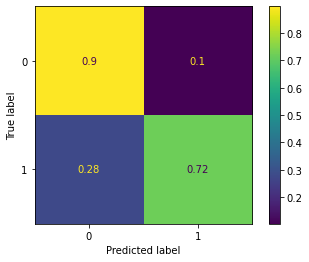

In [35]:
print(classification_report(val_labels, val_pred))
cm = confusion_matrix(val_labels , val_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

## Evaluating performances: 

**What are the strengths and weaknesses of this system? How can they be remedied?**

## To go further: 

In [36]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

## Scikit-learn

### Improving representations

We use the function 
```python
CountVectorizer
``` 
of scikit-learn. It will allow us to easily improve our BoW representations.

#### Tf-idf:

This is the product of the frequency of the term (TF) and its inverse frequency in documents (IDF).
This method is usually used to measure the importance of a term $i$ in a document $j$ relative to the rest of the corpus, from a matrix of occurrences $ words \times documents$. Thus, for a matrix $\mathbf{T}$ of $|V|$ terms and $D$ documents:
$$\text{TF}(T, w, d) = \frac{T_{w,d}}{\sum_{w'=1}^{|V|} T_{w',d}} $$

$$\text{IDF}(T,w) = \log \left(\frac{D}{|\{d: T_{w,d} > 0\}|} \right)$$

$$\text{TF-IDF}(T, w, d) = \text{TF}(T, w, d) \cdot \text{IDF}(T, w)$$

It can be adapted to our case by considering that the context of the second word is the document. However, TF-IDF is generally better suited to low-density matrices, since it will penalize terms that appear in a large part of the documents. 
    
#### Do not take into account words that are too frequent:

We can use the argument
```python
max_df=1.0
```
to change the amount of words taken into account. 

#### Try different granularities:

Rather than just counting words, we can count sequences of words - limited in size, of course. 
We call a sequence of $n$ words a $n$-gram: let's try using 2 and 3-grams (bi- and trigrams).
We can also try to use character sequences instead of word sequences.

We will be interested in the options 
```python
analyze='word'
```
and 
```python
ngram_range=(1, 2)
```
which we'll change to alter the granularity. 

In [37]:
## We can define a pipeline, with which we can experiment.

pipeline_tf_idf = Pipeline([
    ('vect', CountVectorizer(analyzer='word', max_df=0.7, stop_words=None)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
pipeline_tf_idf.fit(train_texts_splt, train_labels_splt)
val_pred = pipeline_tf_idf.predict(val_texts)
print(classification_report(val_labels, val_pred))

              precision    recall  f1-score   support

           0       0.71      0.95      0.81       244
           1       0.93      0.64      0.75       256

    accuracy                           0.79       500
   macro avg       0.82      0.79      0.78       500
weighted avg       0.82      0.79      0.78       500



### Natural Language Toolkit (NLTK)

### Stemming 

Allows to go back to the root of a word: you can group different words around the same root, which facilitates generalization. Use:
```python
from nltk import SnowballStemmer
```

In [38]:
from nltk import SnowballStemmer
stemmer = SnowballStemmer("english")

#### Example:

In [39]:
words = ['singers', 'cat', 'generalization', 'philosophy', 'psychology', 'philosopher']
for word in words:
    print('word : %s ; stemmed : %s' %(word, stemmer.stem(word)))#.decode('utf-8'))))

word : singers ; stemmed : singer
word : cat ; stemmed : cat
word : generalization ; stemmed : general
word : philosophy ; stemmed : philosophi
word : psychology ; stemmed : psycholog
word : philosopher ; stemmed : philosoph


#### Application:

In [40]:
def stem(X): 
    X_stem = []
    for text in X:
        wordlist = []
        for word in text.split(" "):
            stemmword = stemmer.stem(word)#.decode('utf-8'))
            wordlist.append(stemmword)
        X_stem.append(' '.join(wordlist))
    return X_stem

              precision    recall  f1-score   support

           0       0.73      0.89      0.80       244
           1       0.86      0.69      0.77       256

    accuracy                           0.79       500
   macro avg       0.80      0.79      0.78       500
weighted avg       0.80      0.79      0.78       500



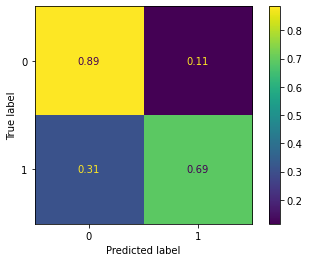

In [41]:
texts_stemmed = stem(train_texts_splt)
val_texts_stemmed = stem(val_texts)
voc, train_bow = count_words(texts_stemmed)
_, val_bow = count_words(val_texts_stemmed, voc)

clf_nb = NB()
clf_nb.fit(train_bow, train_labels_splt)
val_pred = clf_nb.predict(val_bow)

print(classification_report(val_labels, val_pred))
cm = confusion_matrix(val_labels , val_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

### Part of speech tags

To generalize, we can also use the Part of Speech (POS) of the words, which will allow us to filter out information that is potentially not useful to the model. We will retrieve the POS of the words using the functions:
```python
from nltk import pos_tag, word_tokenize
```

In [42]:
import nltk
from nltk import pos_tag, word_tokenize

#### Example:

In [43]:
import nltk
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')

pos_tag(word_tokenize(('I am Sam')))

[('I', 'PRP'), ('am', 'VBP'), ('Sam', 'NNP')]

Details of POS tags meanings: https://stackoverflow.com/questions/15388831/what-are-all-possible-pos-tags-of-nltk

#### Application:

Only keeps nouns, adverbs, verbs and adjectives for our model. 

In [44]:
def pos_tag_filter(X, good_tags=['NN', 'VB', 'ADJ', 'RB']):
    X_pos = []
    for text in X:
        tags = nltk.pos_tag(nltk.word_tokenize(text))
        X_pos.append(' '.join([w for w, t in tags if t in good_tags]))
    return X_pos

              precision    recall  f1-score   support

           0       0.73      0.89      0.80       244
           1       0.86      0.69      0.77       256

    accuracy                           0.79       500
   macro avg       0.80      0.79      0.78       500
weighted avg       0.80      0.79      0.78       500



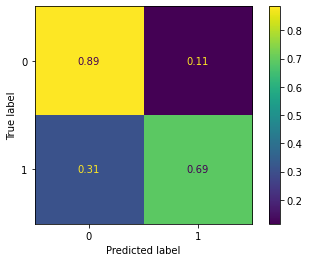

In [45]:
texts_POS = pos_tag_filter(train_texts_splt)
val_texts_POS = pos_tag_filter(val_texts)
voc, train_bow = count_words(texts_stemmed)
_, val_bow = count_words(val_texts_stemmed, voc)

clf_nb = NB()
clf_nb.fit(train_bow, train_labels_splt)
val_pred = clf_nb.predict(val_bow)

print(classification_report(val_labels, val_pred))
cm = confusion_matrix(val_labels , val_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()